In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

ticker = "ANTM.JK"

# Ticker = yf.Ticker(ticker)
# price_history = Ticker.history(period="4y")
# price_history.to_csv(f'{ticker}_price_history_4tahun.csv')

In [3]:
# price_history = pd.read_csv(f'ANTM.JK_price_history_max.csv')
price_history = pd.read_csv('ANTM.JK_price_history_4tahun.csv')
# price_history = pd.read_csv(f'ANTM.JK_price_history_1y.csv')
# price_history = pd.read_csv('ANTM.JK_price_history_10tahun.csv')

In [4]:
price_history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-14 00:00:00+07:00,495.233448,513.921503,476.545394,481.217407,81959800,0.0,0.0
1,2020-05-15 00:00:00+07:00,490.561387,495.233400,471.873334,485.889374,67020800,0.0,0.0
2,2020-05-18 00:00:00+07:00,490.561401,499.905428,485.889388,490.561401,46702500,0.0,0.0
3,2020-05-19 00:00:00+07:00,499.905428,509.249455,490.561401,490.561401,61033100,0.0,0.0
4,2020-05-20 00:00:00+07:00,495.233400,499.905413,476.545347,485.889374,41916400,0.0,0.0


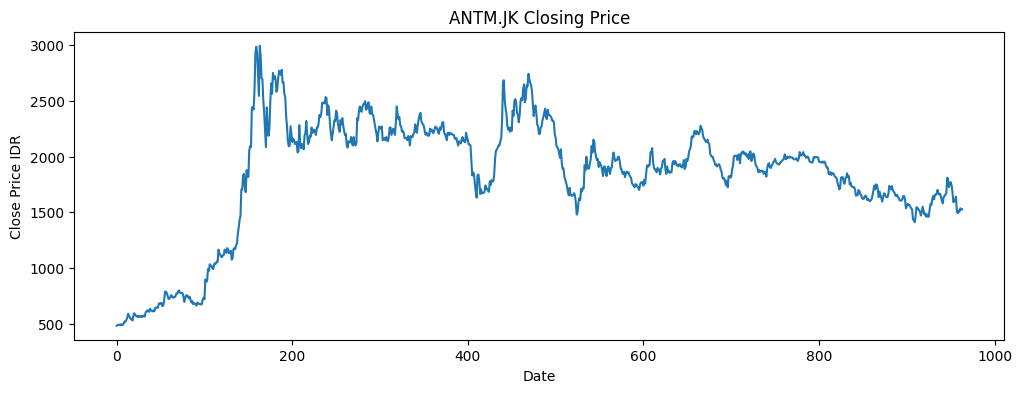

In [5]:
plt.figure(figsize=(12, 4))
plt.title(f'{ticker} Closing Price')
plt.plot(price_history['Close'])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
# plt.legend(['Train'], loc='upper left')
plt.show()

In [6]:
def split_data(data, test_size=0.2):
  data_size = len(data)
  train_size = int(data_size * (1 - test_size))

  data_train = data[:train_size]
  data_test = data[train_size:]

  return data_train, data_test

In [7]:
import numpy as np

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [8]:
price_data_train, price_data_test = split_data(price_history, test_size=0.2) 

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_price_train = scaler.fit_transform(price_data_train['Close'].values.reshape(-1, 1))
scaled_price_test = scaler.fit_transform(price_data_test['Close'].values.reshape(-1, 1))

In [10]:
SEQUENCE_LENGTH = 90 # Prediction time window

X_train, y_train = create_sequences(scaled_price_train, seq_length=SEQUENCE_LENGTH)
X_test, y_test = create_sequences(scaled_price_test, seq_length=SEQUENCE_LENGTH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras import optimizers

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16))
model.add(Dense(1))

opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')

# model.compile(optimizer='adam', loss='mse') # default lr = 10e-3

print(model.summary())

2024-06-13 12:14:16.253187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 12:14:16.253894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 12:14:16.355468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 12:14:16.542139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 12:14:18.391454: W tensorflow/compiler/tf2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 90, 128)           33792     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 76065 (297.13 KB)
Trainable params: 76065 (297.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(filepath='model.weights.h5', monitor='loss', save_weights_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/30


2024-06-13 12:14:35.580406: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/kevin/anaconda3/envs/tf/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2024-06-13 12:14:36.382125: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3bcc07b4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-13 12:14:36.382192: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-13 12:14:36.402547: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718255676.560537    3303 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 15s 142ms/step - loss: 0.1407 - val_loss: 0.0870
Epoch 2/30
22/22 [==============================] - 1s 64ms/step - loss: 0.0129 - val_loss: 0.0372
Epoch 3/30
22/22 [==============================] - 1s 59ms/step - loss: 0.0059 - val_loss: 0.0119
Epoch 4/30
22/22 [==============================] - 1s 61ms/step - loss: 0.0032 - val_loss: 0.0106
Epoch 5/30
22/22 [==============================] - 1s 65ms/step - loss: 0.0031 - val_loss: 0.0101
Epoch 6/30
22/22 [==============================] - 1s 64ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 7/30
22/22 [==============================] - 1s 60ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 8/30
22/22 [==============================] - 1s 61ms/step - loss: 0.0025 - val_loss: 0.0087
Epoch 9/30
22/22 [==============================] - 1s 60ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 10/30
22/22 [==============================] - 1s 61ms/step - loss: 0.0019 - val_loss: 0.0079
Epoch 11/30
22/22 

In [13]:
# LSTM prediction

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE LSTM  : {mse:.7f}")
print(f"RMSE LSTM : {rmse:.7f}")
print(f"MAE LSTM  : {mae:.7f}")


4/4 [==============================] - 2s 34ms/step
MSE LSTM  : 0.0056913
RMSE LSTM : 0.0754406
MAE LSTM  : 0.0566409


In [14]:
y_pred_rescaled = scaler.inverse_transform(y_pred) 

In [15]:
train_size = len(price_data_train)
train_price_plot = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot['Prediction'] = y_pred_rescaled.flatten()

/tmp/ipykernel_1921/1873714381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot['Prediction'] = y_pred_rescaled.flatten()


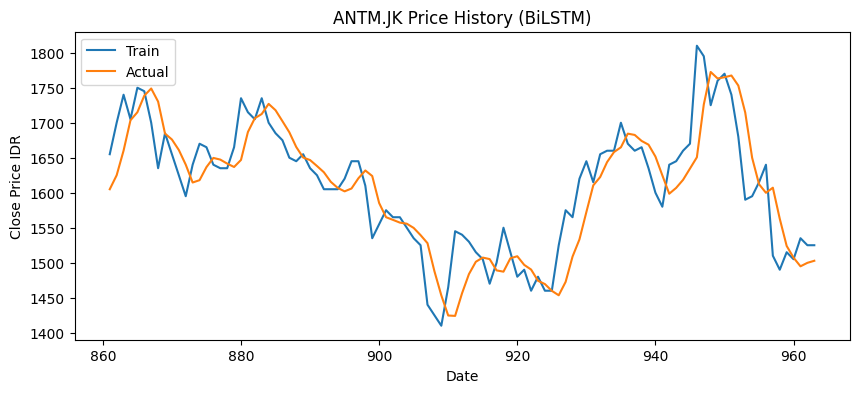

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))
plt.title(f'{ticker} Price History (BiLSTM)')
# plt.plot(train_price_plot['Close'])
plt.plot(test_price_plot[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()

# RandomForestRegressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

X_train_2d = X_train.squeeze()
y_train_1d = y_train.squeeze()

rf = RandomForestRegressor(n_estimators= 100, random_state=42)
rf.fit(X_train_2d, y_train_1d)

RandomForestRegressor(random_state=42)

In [18]:
print([estimator.tree_.max_depth for estimator in rf.estimators_])

[18, 18, 18, 19, 19, 18, 16, 17, 16, 25, 17, 20, 18, 20, 17, 17, 17, 19, 18, 22, 17, 18, 18, 16, 17, 16, 19, 15, 20, 20, 16, 18, 19, 19, 17, 18, 19, 17, 19, 16, 19, 17, 18, 19, 20, 15, 15, 19, 17, 18, 17, 20, 19, 17, 17, 17, 17, 16, 18, 18, 19, 17, 18, 18, 20, 18, 18, 19, 17, 23, 17, 15, 19, 20, 17, 18, 20, 20, 18, 16, 15, 18, 17, 17, 17, 15, 19, 17, 18, 18, 19, 18, 17, 19, 21, 19, 18, 17, 21, 17]


In [19]:
# print the random forest n_estimators
print(rf.n_estimators)

100


In [20]:
X_test_2d = X_test.squeeze()

y_pred_rf = rf.predict(X_test_2d)
y_test_1d = y_test.squeeze()

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)

print(f"MSE RF  : {mse:.7f}")
print(f"RMSE RF : {rmse:.7f}")
print(f"MAE RF  : {mae:.7f}")


MSE RF  : 0.0235841
RMSE RF : 0.1535711
MAE RF  : 0.1215012


In [21]:
y_pred_rescaled_rf = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))

In [22]:
train_size = len(price_data_train)
train_price_plot_rf = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot_rf = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()

/tmp/ipykernel_1921/11579854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()


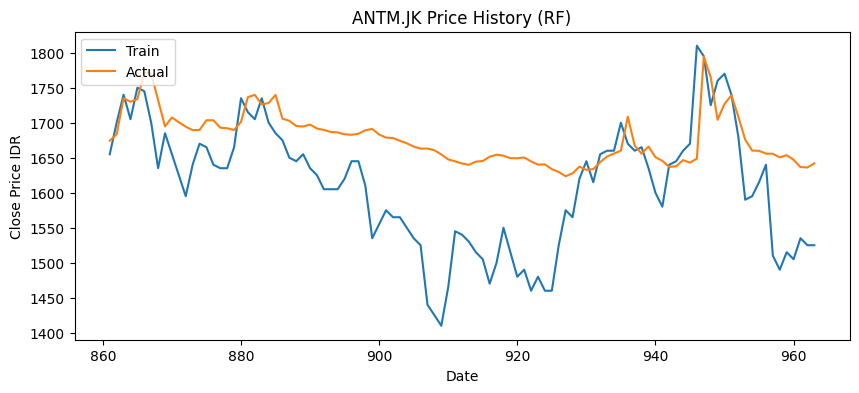

In [29]:
plt.figure(figsize=(10, 4))
plt.title(f'{ticker} Price History (RF)')
# plt.plot(train_price_plot_rf['Close'])
plt.plot(test_price_plot_rf[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()

## **Plot Comparisons**

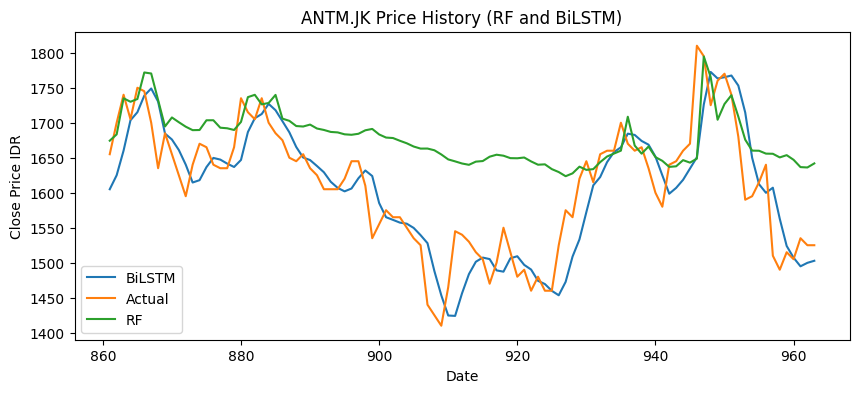

In [30]:
plt.figure(figsize=(10, 4))
plt.title(f'{ticker} Price History (RF and BiLSTM)')
# plt.plot(train_price_plot_rf['Close'])
plt.plot(test_price_plot[['Prediction']])
plt.plot(test_price_plot_rf[['Close']])
plt.plot(test_price_plot_rf[['Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['BiLSTM', 'Actual', 'RF'], loc='lower left')
plt.show()